In [3]:
import numpy as np
import pandas as pd
import os
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose                     
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import SimpleRNN
from keras.layers import GRU
import tensorflow as tf
import seaborn as sns
import pandas as pd
import matplotlib.pyplot  as plt

%matplotlib inline

Загрузка датасета

In [4]:
df = pd.read_csv('monthly_champagne_sales.csv')

Описание

In [5]:
df.head()

,Month,Sales
0,1964-01,2815
1,1964-02,2672
2,1964-03,2755
3,1964-04,2721
4,1964-05,2946


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105 entries, 0 to 104
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Month   105 non-null    object
 1   Sales   105 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 1.8+ KB


In [7]:
df.Month = pd.to_datetime(df.Month)
df = df.set_index("Month")
df.head()

,Sales
Month,
1964-01-01,2815
1964-02-01,2672
1964-03-01,2755
1964-04-01,2721
1964-05-01,2946


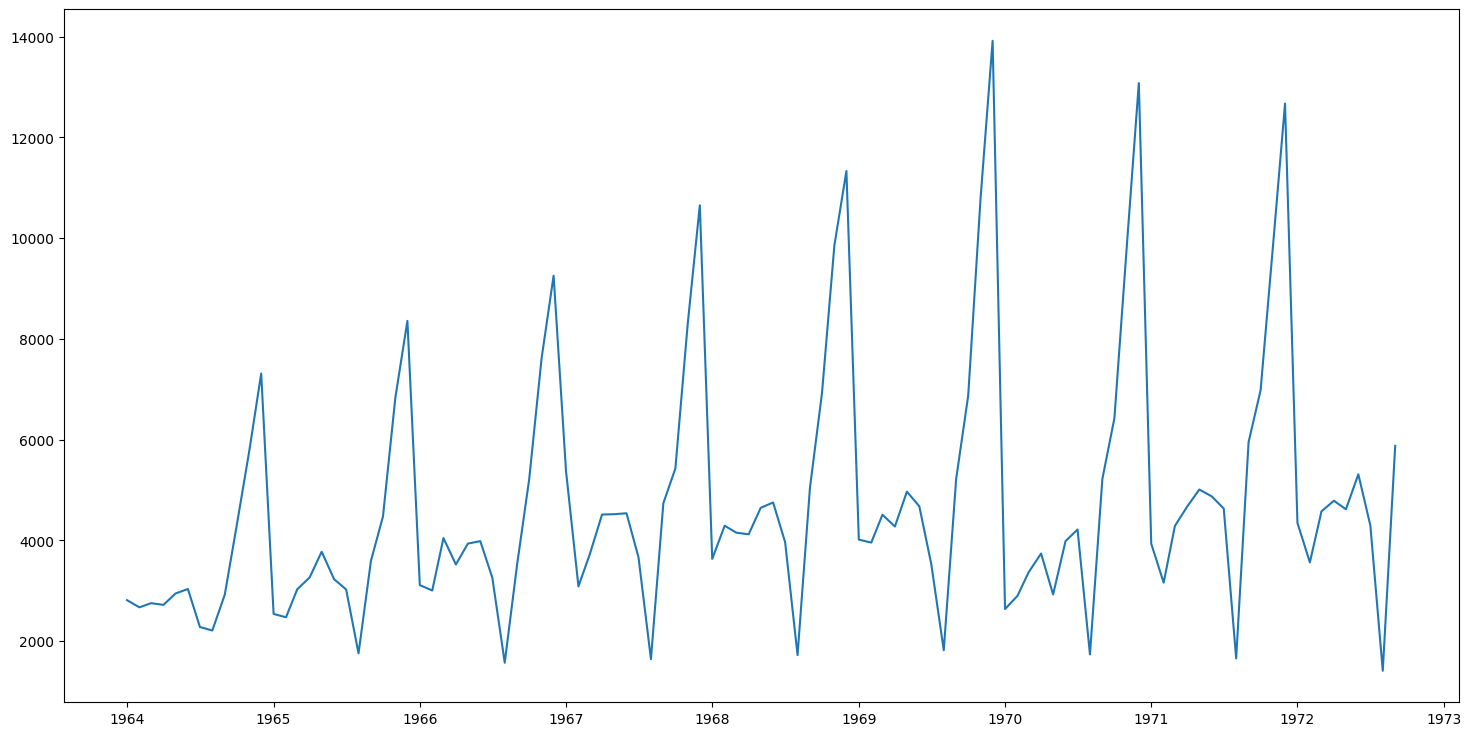

In [8]:
plt.figure(figsize=(18,9))
plt.plot(df.index, df["Sales"], linestyle="-")
plt.xlabel=('Dates')
plt.ylabel=('Total Production')
plt.show();

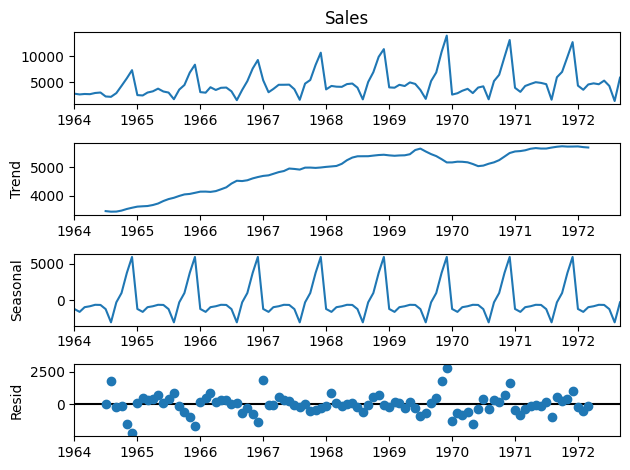

In [9]:
a = seasonal_decompose(df["Sales"], model = "add")
a.plot();

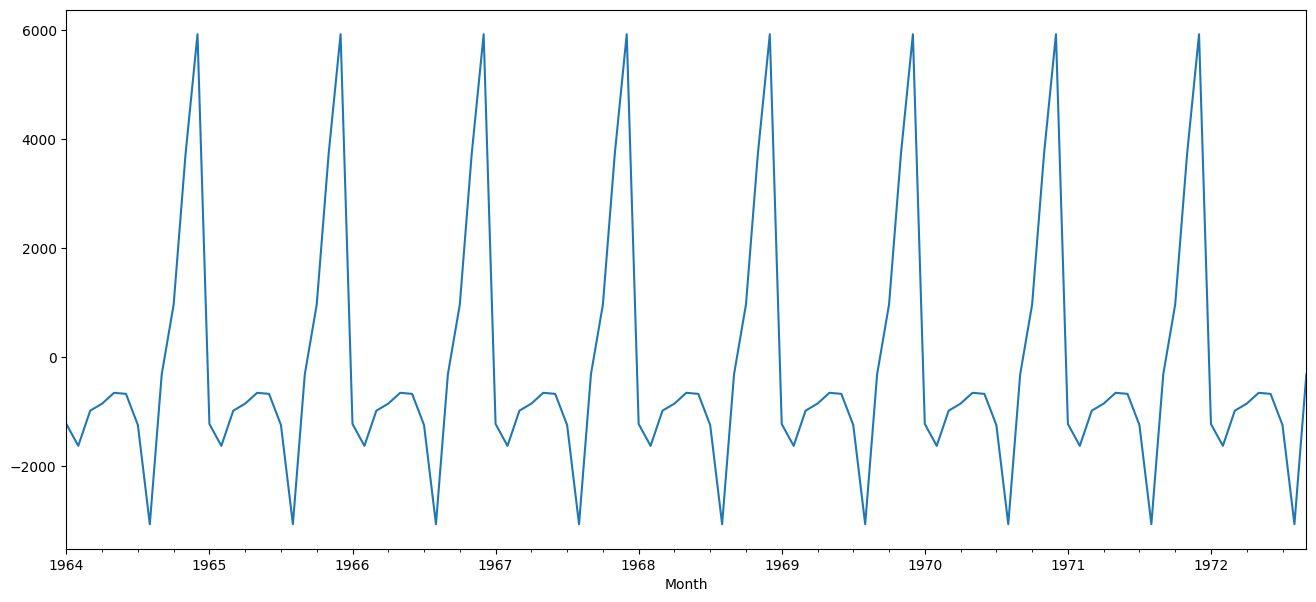

In [10]:
plt.figure(figsize = (16,7))
a.seasonal.plot();

p-value

In [11]:
adf_test = adfuller(df["Sales"])
print('p-value = ' + str(adf_test[1]))

if adf_test[1] > 0.05:
    print('it is not a stationary process')
else:
    print('it is a stationary process')

p-value = 0.36391577166024586
it is not a stationary process


ARIMA

In [12]:
train_data = df[:len(df)-12]
print(train_data)
test_data = df[len(df)-12:]

            Sales
Month            
1964-01-01   2815
1964-02-01   2672
1964-03-01   2755
1964-04-01   2721
1964-05-01   2946
...           ...
1971-05-01   5010
1971-06-01   4874
1971-07-01   4633
1971-08-01   1659
1971-09-01   5951

[93 rows x 1 columns]


In [13]:
arima_model = SARIMAX(train_data['Sales'], order = (1,1,1), seasonal_order = (1,1,1,12))
#arima_model = ARIMA(train_data['Sales'], order=(5,1,0))
arima_result = arima_model.fit()
arima_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Sales   No. Observations:                   93
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -645.640
Date:                            Wed, 31 May 2023   AIC                           1301.280
Time:                                    01:45:04   BIC                           1313.190
Sample:                                01-01-1964   HQIC                          1306.055
                                     - 09-01-1971                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2985      0.090      3.304      0.001       0.121       0.476
ma.L1         -0.9465      0.049    -19.127      0.000      -1.043      -0.850
ar.S.L12      -0.6172      0.269     -2.294      0.022      -1.145      -0.090
ma.S.L12       0.3745      0.282      1.328      0.184      -0.178       0.927
sigma2      5.398e+05   7.17e+04      7.530      0.000    3.99e+05     6.8e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.29   Jarque-Bera (JB):                 4.66
Prob(Q):                              0.59   Prob(JB):                         0.10
Heteroskedasticity (H):               1.91   Skew:                            -0.20
Prob(H) (two-sided):                  0.10   Kurtosis:                         4.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [14]:
arima_pred = arima_result.predict(start = len(train_data), end = len(df)-1, typ="levels").rename("ARIMA Predictions")
arima_pred

1971-10-01     6874.877470
1971-11-01    10420.996091
1971-12-01    13783.839517
1972-01-01     3720.403501
1972-02-01     3297.672047
1972-03-01     4224.271099
1972-04-01     4652.485837
1972-05-01     4573.933414
1972-06-01     4866.862563
1972-07-01     4879.099386
1972-08-01     1935.044747
1972-09-01     6032.541790
Freq: MS, Name: ARIMA Predictions, dtype: float64

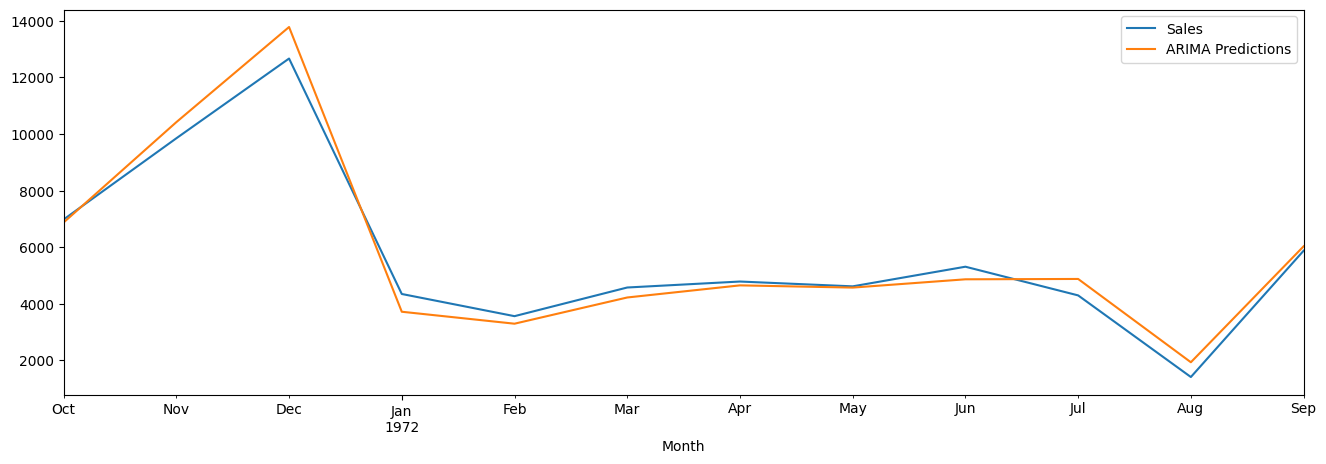

In [15]:
test_data['Sales'].plot(figsize = (16,5), legend=True)
arima_pred.plot(legend = True);

In [16]:
arima_rmse_error = rmse(test_data['Sales'], arima_pred)
arima_mse_error = arima_rmse_error**2
arima_mae_error = mean_absolute_error(test_data['Sales'], arima_pred)
mean_value = df['Sales'].mean()

print(f'MSE Error: {arima_mse_error}\nRMSE Error: {arima_rmse_error}\nMean: {mean_value}')

MSE Error: 251572.94826250363
RMSE Error: 501.57048184926475
Mean: 4761.152380952381


In [17]:
global_test_data = test_data.copy()
global_test_data['ARIMA_Predictions'] = arima_pred

rnn

In [18]:
scaler = MinMaxScaler()

scaler.fit(train_data)
scaled_train_data = scaler.transform(train_data)
scaled_test_data = scaler.transform(test_data)

In [19]:
n_input = 12
n_features= 1
generator = TimeseriesGenerator(scaled_train_data, scaled_train_data, length=n_input, batch_size=1)

In [20]:
#rnn_model = Sequential()
#rnn_model.add(SimpleRNN(100, activation='relu', input_shape=(n_input, n_features)))
#rnn_model.add(Dense(1))


'''
    tf.keras.layers.Conv1D(filters=64, kernel_size=2,
                           strides=1, padding="causal",
                           activation="relu",
                           input_shape=[n_input, n_features]),
'''


rnn_model = tf.keras.Sequential([
    tf.keras.Input(shape=(n_input, n_features)),
    tf.keras.layers.LSTM(40),
    tf.keras.layers.Dense(40, activation='relu'),
    tf.keras.layers.Dense(1)
])

rnn_model.compile(optimizer='adam', loss='mse')

rnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 40)                6720      
                                                                 
 dense (Dense)               (None, 40)                1640      
                                                                 
 dense_1 (Dense)             (None, 1)                 41        
                                                                 
Total params: 8,401
Trainable params: 8,401
Non-trainable params: 0
_________________________________________________________________


In [21]:
rnn_model.fit_generator(generator, epochs=25)

Epoch 1/25
81/81 [==============================] - 8s 4ms/step - loss: 0.0456
Epoch 2/25
81/81 [==============================] - 0s 4ms/step - loss: 0.0434
Epoch 3/25
81/81 [==============================] - 0s 4ms/step - loss: 0.0432
Epoch 4/25
81/81 [==============================] - 0s 4ms/step - loss: 0.0395
Epoch 5/25
81/81 [==============================] - 0s 4ms/step - loss: 0.0302
Epoch 6/25
81/81 [==============================] - 0s 4ms/step - loss: 0.0252
Epoch 7/25
81/81 [==============================] - 0s 5ms/step - loss: 0.0132
Epoch 8/25
81/81 [==============================] - 0s 5ms/step - loss: 0.0218
Epoch 9/25
81/81 [==============================] - 0s 4ms/step - loss: 0.0118
Epoch 10/25
81/81 [==============================] - 0s 4ms/step - loss: 0.0110
Epoch 11/25
81/81 [==============================] - 0s 4ms/step - loss: 0.0125
Epoch 12/25
81/81 [==============================] - 0s 4ms/step - loss: 0.0094
Epoch 13/25
81/81 [==============================

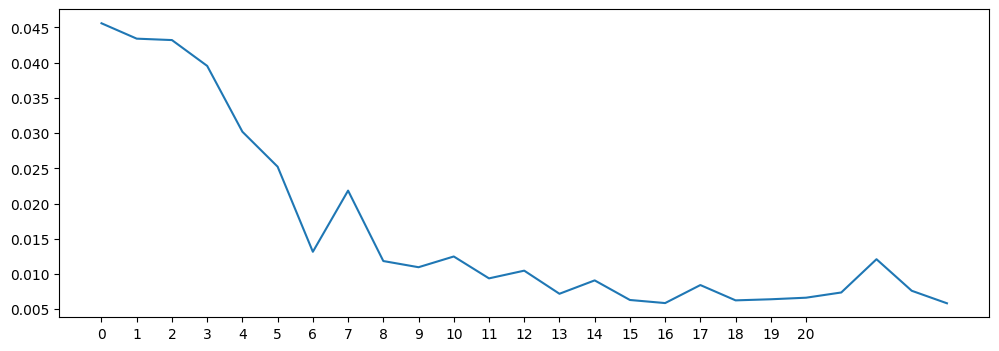

In [22]:
losses_rnn = rnn_model.history.history['loss']
plt.figure(figsize=(12,4))
plt.xticks(np.arange(0,21,1))
plt.plot(range(len(losses_rnn)),losses_rnn);

In [23]:
RNN_Predictions_scaled = list()

# last n_input elements
batch = scaled_train_data[-n_input:]
print('batch')
print(batch)
print('shape is ', batch.shape)
# shape now is (1, 12, 1)
current_batch = batch.reshape((1, n_input, n_features))
print('current batch')
print(current_batch)
print('shape is ', current_batch.shape)
for i in range(len(test_data)):   
    rnn_pred = rnn_model.predict(current_batch)[0]
    RNN_Predictions_scaled.append(rnn_pred) 
    # first element in current_batch will be gone
    # a new element will be inserted at the end
    current_batch = np.append(current_batch[:,1:,:],[[rnn_pred]],axis=1)
    print('current_batch now\n', current_batch)
    print('current_batch shape\n', current_batch.shape)

batch
[[0.39301628]
 [0.66993438]
 [0.93194523]
 [0.19128251]
 [0.12873694]
 [0.2198007 ]
 [0.25139755]
 [0.27845743]
 [0.26743903]
 [0.2479138 ]
 [0.00696751]
 [0.35469497]]
shape is  (12, 1)
current batch
[[[0.39301628]
  [0.66993438]
  [0.93194523]
  [0.19128251]
  [0.12873694]
  [0.2198007 ]
  [0.25139755]
  [0.27845743]
  [0.26743903]
  [0.2479138 ]
  [0.00696751]
  [0.35469497]]]
shape is  (1, 12, 1)
1/1 [==============================] - 0s 397ms/step
current_batch now
 [[[0.66993438]
  [0.93194523]
  [0.19128251]
  [0.12873694]
  [0.2198007 ]
  [0.25139755]
  [0.27845743]
  [0.26743903]
  [0.2479138 ]
  [0.00696751]
  [0.35469497]
  [0.40565246]]]
current_batch shape
 (1, 12, 1)
1/1 [==============================] - 0s 19ms/step
current_batch now
 [[[0.93194523]
  [0.19128251]
  [0.12873694]
  [0.2198007 ]
  [0.25139755]
  [0.27845743]
  [0.26743903]
  [0.2479138 ]
  [0.00696751]
  [0.35469497]
  [0.40565246]
  [0.6007669 ]]]
current_batch shape
 (1, 12, 1)
1/1 [==============

In [24]:
RNN_Predictions_scaled

[array([0.40565246], dtype=float32),
 array([0.6007669], dtype=float32),
 array([0.7918817], dtype=float32),
 array([0.21749777], dtype=float32),
 array([0.2219978], dtype=float32),
 array([0.2214508], dtype=float32),
 array([0.22313702], dtype=float32),
 array([0.21084833], dtype=float32),
 array([0.19771636], dtype=float32),
 array([0.17227957], dtype=float32),
 array([0.13116983], dtype=float32),
 array([0.2889118], dtype=float32)]

In [25]:
RNN_Predictions = scaler.inverse_transform(RNN_Predictions_scaled)

In [26]:
global_test_data['RNN_Predictions'] = RNN_Predictions

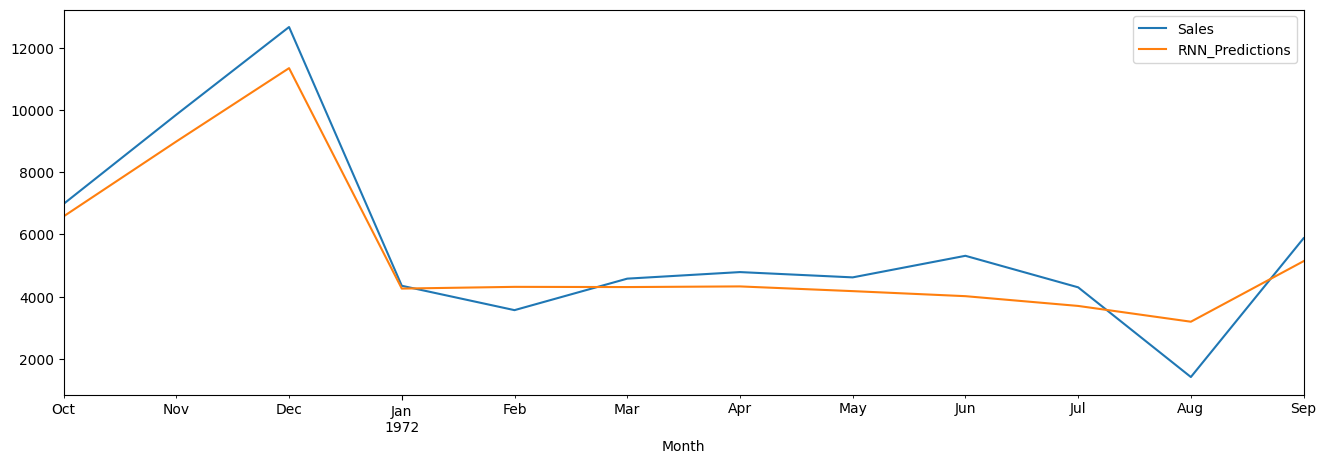

In [27]:
global_test_data['Sales'].plot(figsize = (16,5), legend=True)
global_test_data['RNN_Predictions'].plot(legend = True);

In [28]:
rnn_rmse_error = rmse(global_test_data['Sales'], global_test_data["RNN_Predictions"])
rnn_mse_error = rnn_rmse_error**2
rnn_mae_error = mean_absolute_error(global_test_data['Sales'], global_test_data["RNN_Predictions"])
mean_value = df['Sales'].mean()

print(f'MSE Error: {rnn_mse_error}\nRMSE Error: {rnn_rmse_error}\nMean: {mean_value}')

MSE Error: 788319.4046289995
RMSE Error: 887.8735296364001
Mean: 4761.152380952381


In [29]:
rmse_errors = [arima_rmse_error, rnn_rmse_error]
mse_errors = [arima_mse_error, rnn_mse_error]
mae_errors = [arima_mae_error, rnn_mae_error]

In [30]:
errors = pd.DataFrame({"Models" : ["ARIMA", "RNN"],"RMSE Error" : rmse_errors, "MSE Error" : mse_errors,"MAE Error": mae_errors})

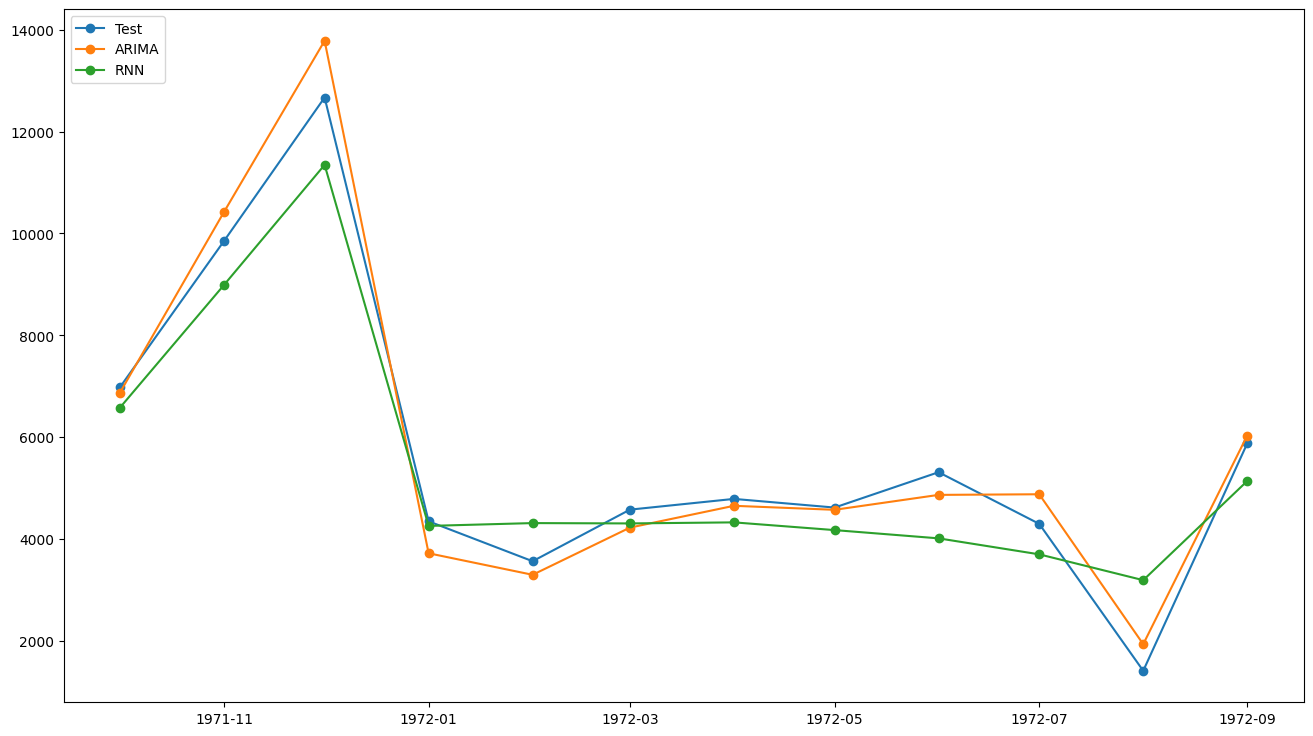

In [31]:
plt.figure(figsize=(16,9))
plt.plot_date(global_test_data.index, global_test_data["Sales"], linestyle="-")
plt.plot_date(global_test_data.index, global_test_data["ARIMA_Predictions"], linestyle="-")
plt.plot_date(global_test_data.index, global_test_data["RNN_Predictions"], linestyle="-")
plt.legend(["Test", "ARIMA", 'RNN'], loc ="upper left")
plt.show()

In [32]:
print(f"Mean: {global_test_data['Sales'].mean()}")
errors

Mean: 5691.416666666667


,Models,RMSE Error,MSE Error,MAE Error
0,ARIMA,501.570482,251572.948263,410.001300
1,RNN,887.873530,788319.404629,751.183076


In [33]:
global_test_data

,Sales,ARIMA_Predictions,RNN_Predictions
Month,,,
1971-10-01,6981,6874.877470,6579.968356
1971-11-01,9851,10420.996091,8988.265812
1971-12-01,12670,13783.839517,11347.195582
1972-01-01,4348,3720.403501,4257.574926
1972-02-01,3564,3297.672047,4313.118814
1972-03-01,4577,4224.271099,4306.367294
1972-04-01,4788,4652.485837,4327.180251
1972-05-01,4618,4573.933414,4175.500955
1972-06-01,5312,4866.862563,4013.412974
